In [43]:
import kwant 
import numpy as np
import matplotlib.pyplot as plt
from kwant.continuum import discretize
import matplotlib as mpl
import jospehson_current_tools as jct
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})
%matplotlib widget 



In [44]:
from dataclasses import dataclass, asdict

@dataclass
class System_parameters:
    a : float
    A : float
    B : float
    C : float
    Delta : float
    mu : float
    d_y : float # Width of the normal QAH region (see overleaf notes for axis convention)
    d_x : float # Length of the normal QAH region (see overleaf notes for axis convention)
    flux : float # Total flux penetrating the normal QAH region.
    k: float # Boltzmann constant
    T: float # Temperature
    current_unit : float # Current unit


In [45]:
def make_josephson_junction(params):
    syst = kwant.Builder()

    # Scaled dimensions:
    d_x = params.d_x // params.a
    d_y = params.d_y // params.A

    # This time I'm going to experiment with kwant.continuum.discretize.

    qhz_hamiltonian = """ 
    A*k_x*kron(sigma_z , sigma_x) + A*k_y*kron(sigma_z , sigma_y) + B*(k_x^2 + k_y^2)*kron(sigma_0 , sigma_z)
    + C*kron(sigma_0 , sigma_z) + Delta*kron(sigma_x , sigma_0) - mu*kron(sigma_z , sigma_0)
    """

    template_lead = kwant.continuum.discretize(qhz_hamiltonian , grid = params.a)
    template_normal = kwant.continuum.discretize(qhz_hamiltonian , locals = {'Delta' : 0} , grid = params.a)
    
    syst.fill(template_normal, lambda s: 0 <= s.pos[0] < d_y and 0 <= s.pos[1] < d_x, (0, 0))
    lat = template_normal.lattice

    # Getting cuts and adding virtual leads to the cuts:
    cuts= jct.get_cuts(syst , lat)
    syst = jct.add_vlead(syst , lat , *cuts , asdict(params))

    # Adding superconducting leads now:
    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))
    lead.fill(template_lead , lambda s: 0 <= s.pos[1]< d_x , (0 , 0) )
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
                     
    syst = syst.finalized()

    hopping = jct.hopping_between_cuts(syst, *cuts)

    return syst , hopping

params = System_parameters(a = 1 , A = 1, B = 1 , C = -0.2 , Delta = 1 , mu = 0 , d_y = 10 , d_x = 5 , flux = 0 , k = jct.constants.k , T = 0.01 
                           , current_unit = jct.constants.current_unit)
syst , hopping = make_josephson_junction(params)


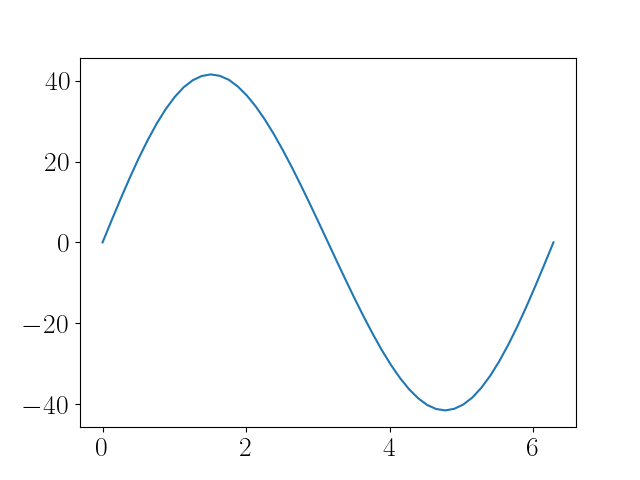

In [48]:
phases = np.linspace(0 , 2*np.pi , 51)
CPR = jct.calculate_CPR(syst, hopping , asdict(params) , phases , tol = 1e-3 )

plt.figure()
plt.plot(phases , CPR)


In [85]:
# CPRS and critical currents as we walk throught the phase diagram:
C_values = np.linspace(-1.5 , 1.5 , 21)
phases = np.linspace(0 , 2*np.pi , 21)
data = []

from tqdm import tqdm
for i in tqdm(range(len(C_values))):
    params = System_parameters(a = 1 , A = 1, B = 1 , C = C_values[i] , Delta = 1 , mu = 0 , d_y = 30 , d_x = 30 , flux = 0 , k = jct.constants.k , T = 1e-3
                           , current_unit = jct.constants.current_unit)
    syst , hopping = make_josephson_junction(params)
    data.append(jct.I_c(syst , hopping , asdict(params)))

100%|██████████| 21/21 [20:28<00:00, 58.49s/it]


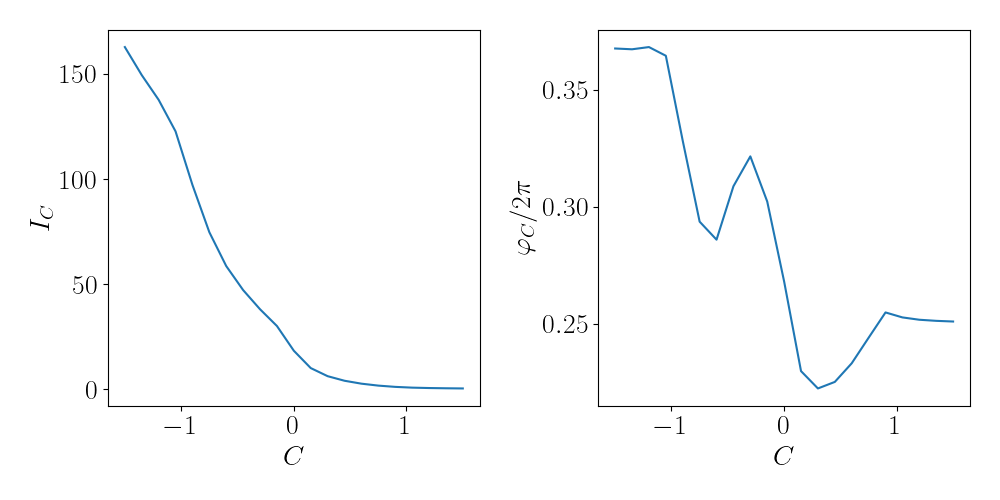

In [86]:
# Extracting critical currents and phases from the data array:
phase_c = np.zeros_like(C_values)
current_c = np.zeros_like(C_values)
for i in range(len(data)):
    phase_c[i] = data[i]['phase_c']
    current_c[i] = data[i]['current_c']

fig , ax = plt.subplots(nrows= 1 , ncols = 2 )
fig.set_figwidth(10)
fig.set_figheight(5)    
ax[0].plot(C_values , current_c)
ax[0].set_xlabel(r'$C$')
ax[0].set_ylabel(r'$I_{C}$')
ax[1].plot(C_values , phase_c / (2*np.pi))
ax[1].set_xlabel(r'$C$')
ax[1].set_ylabel(r'$\varphi_{C} / 2\pi$')
plt.tight_layout()